Philippe Joly 2024-07-08

# Football Field Line Detection

This is a reproduction of the techniques used by [Junru Wang and Yuxuan Liu](https://mulab.ai/project/499-22-sports-analytics/) to detect lines on a football field. Various preprocessing techniques along with Hough Lines algorithm will be used to accomplish this task

## Loading Image

In [151]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [152]:
test_imgs = [
    "./test_images/field.jpeg",
    "./test_images/field2.jpg",
    "./test_images/test_img.png",
    "./test_images/test_img2.png"
]

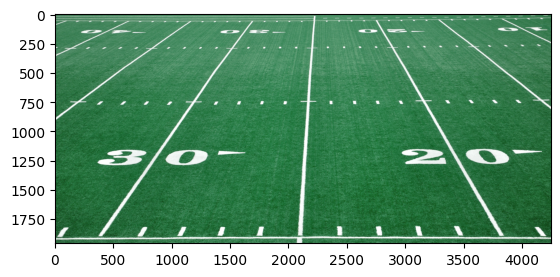

In [153]:
img_og = cv2.imread(test_imgs[0])
plt.imshow(img_og)

## Preprocessing

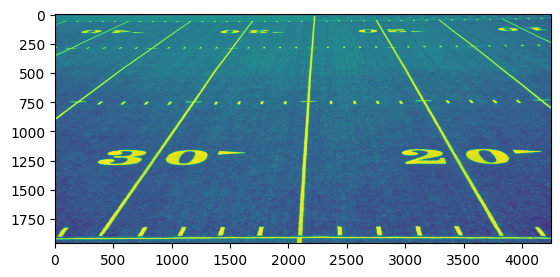

In [154]:
img = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

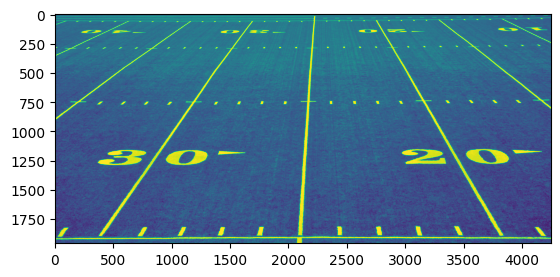

In [155]:
img = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(img)

## Line Detection

In [156]:
# edge detection using canny
edges = cv2.Canny(img, 75, 120)

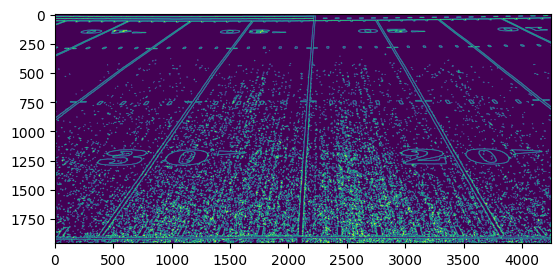

In [157]:
# dilation to enhance edges
kernel = np.ones((3,3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges)

In [158]:
# Hough Lines
## params
rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 100  # Accumulator threshold
minLineLength = 200  # Minimum length of a line
maxLineGap = 10  # Maximum allowed gap between points on the same line

lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

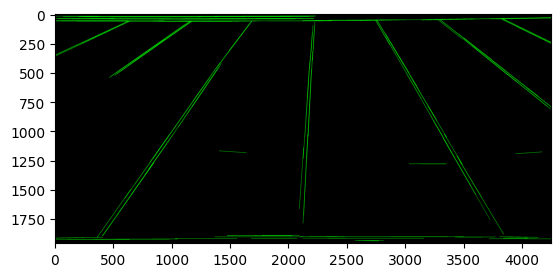

In [159]:
lines_draw = np.zeros_like(img_og)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(lines_draw)

## Merge Lines

In [160]:
def get_dis(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_basis(p1, p2):
    return p2-p1

def get_angles(p1, p2):
    basis = get_basis(p1,p2)

    angle1 = np.rad2deg(np.atan2(basis[1], basis[0]))
    angle2 = angle1 + 180

    if angle1 < 0:
        angle1 = 360 + angle1

    return [angle1, angle2]

def project(basis, v):
    return (np.dot(v, basis)/np.dot(v, v) * v).astype(np.int64)

In [161]:
line_list = []
for id, line in enumerate(lines):
    p1 = np.array(line[0][:2])
    p2 = np.array(line[0][2:])
    line_list.append({'id': id+1, 'p1': p1, 'p2': p2, 'len': get_dis(p1, p2), 'basis': get_basis(p1, p2), 'angles': get_angles(p1, p2), 'merged': False, 'merges': 0})
line_list.sort(key=lambda x: x['len'])

In [162]:
def get_closest_pt(basis_line, p_l2):
    a, b = basis_line['p1'],basis_line['p2']
    u = b-a
    v = p_l2-a

    t = np.dot(u,v)/np.dot(u,u)
    
    if t <= 0:
        return a
    elif t >= 1:
        return b
    
    return (a+t*(b-a)).astype(np.int64)
 
def dis_to_line(basis_line, p_l2):
    p_l1 = get_closest_pt(basis_line, p_l2)
    return get_dis(p_l1, p_l2)

def merge_lines(basis_line, merged_line):
    a, b = basis_line['p1'],basis_line['p2']
    u = b-a
    v1 = merged_line['p1']-a
    v2 = merged_line['p2']-a

    t1 = np.dot(u,v1)/np.dot(u,u)
    t2 = np.dot(u,v2)/np.dot(u,u)

    c1 = (a+t1*(b-a)).astype(np.int64)
    c2 = (a+t2*(b-a)).astype(np.int64)

    if t1 <= 0:
        basis_line['p1'] = c1
    elif t1 >= 1:
        basis_line['p2'] = c1

    if t2 <= 0 and t2 <= t1:
        basis_line['p1'] = c2
    elif t2 >= 1 and t2 >= t1:
        basis_line['p2'] = c2

    merged_line['merged'] = basis_line['id']
    basis_line['merges'] += 1  

    ### ***handle out of bounds projections*** 
    

In [163]:
def should_merge(basis_line, merged_line, angle_treshold, dis_treshold):
    # the edges of merged_line suffice to find closest distance between the 2 lines as they are supposidely parallel and the merged_line is always shorter than the basis_line (sorted)
   
    delta_angle = min(
        abs(basis_line['angles'][0] - merged_line['angles'][0]),
        abs(basis_line['angles'][1] - merged_line['angles'][0]),
        abs(basis_line['angles'][0] - merged_line['angles'][1]),
        abs(basis_line['angles'][0] - merged_line['angles'][0])
    )

    if delta_angle < angle_treshold:
        dis_p1 = dis_to_line(basis_line, merged_line['p1'])
        dis_p2 = dis_to_line(basis_line, merged_line['p2'])

        if dis_p1 < dis_treshold or dis_p2 < dis_treshold:
            return True    
    return False    

In [164]:
# main merging loop
list_length = len(line_list)
for i in range(list_length-1):
    for j in range(list_length-1, i, -1):
        if should_merge(line_list[j], line_list[i], 5, 50):
            merge_lines(line_list[j], line_list[i])
            break
merged_lines = [l for l in line_list if not l['merged']]

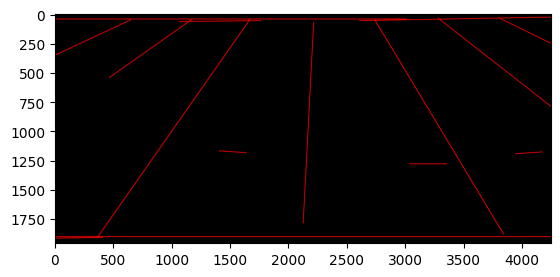

In [165]:
lines_draw = np.zeros_like(lines_draw)
if merged_lines is not None:
    for line in merged_lines:
        cv2.line(lines_draw, (line['p1'][0], line['p1'][1]), (line['p2'][0], line['p2'][1]), (255, 0, 0), 5)

plt.imshow(lines_draw)